# Animal Classification with Inception

## Problem

Classification for images has a lot of studies and documentation in the deep learning community. This project will focus on Google's idea of an "inception module" proposed in [Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842v1) \[1]. A basic Convolutional Neural Network (CNN) will be trained and then inception modules as Google defines them will be added in the architecture to measure performance.

The data chosen is the [Kaggle Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10) dataset, in which ten categories of animals are organized by jpeg images.

The goal of this project is to accurately categorize the animal images into the correct animal and explore Google's inception module capability in increasing perfomance.

For this paper, I am using Google Colab with the data unzipped and loaded in a Google drive. The code below will mount the Google drive.

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

First, let us explore the dataset.

The data is organized by category for us. The labels are in Italian, but the data package from Kaggle gives us a translation json here:

In [2]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
             "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse",
             "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno",
             "squirrel": "scoiattolo"}

Before coding is done, GPU and high RAM computing must be enabled. The following code is provided by Google for use in [Google Colab](https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf).

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Mar  3 21:18:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

For the purposes of this paper, the Italian classifications will be used in the model, and the English will be referenced from this json object for the documentation.

Now, a sample image will be pulled from each category as reference.

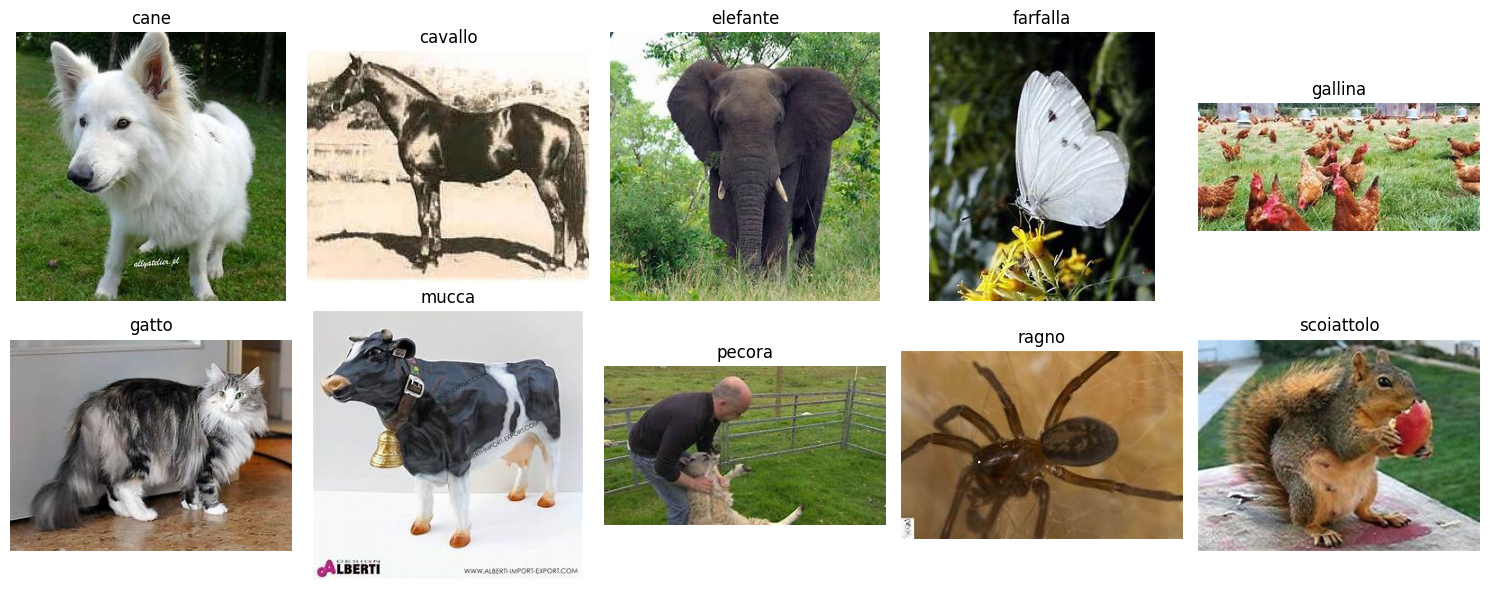

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load and display images in a grid
def display_image_grid(folder_path, img_number):
    # Get a list of folder names (categories)
    categories = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    categories.sort()

    # Initialize the figure for the grid (5x2)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, ax in enumerate(axes.flat):
        category = categories[i]
        category_path = os.path.join(folder_path, category)

        # Grab the first JPEG image in the category folder
        image_files = [f for f in os.listdir(category_path) if f.endswith(".jpeg") or f.endswith(".jpg")]
        if image_files:
            first_image_path = os.path.join(category_path, image_files[img_number])

            # Load and display the image
            image = mpimg.imread(first_image_path)
            ax.imshow(image)

            # Set title to folder name
            ax.set_title(category)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Generate Visual
display_image_grid("/content/drive/MyDrive/Deep Learning Final Project/data/raw-img", 0)

### Observations

1. Image size is inconsistent
2. Animal location in picture is inconsistent
3. Borders around the image may be present
4. Blurring and image quality are inconsistent
5. More than one of the same animal may be present
6. Another animal (human in the horse picture) may be present

Now we will view the second image in each category for other possible observations

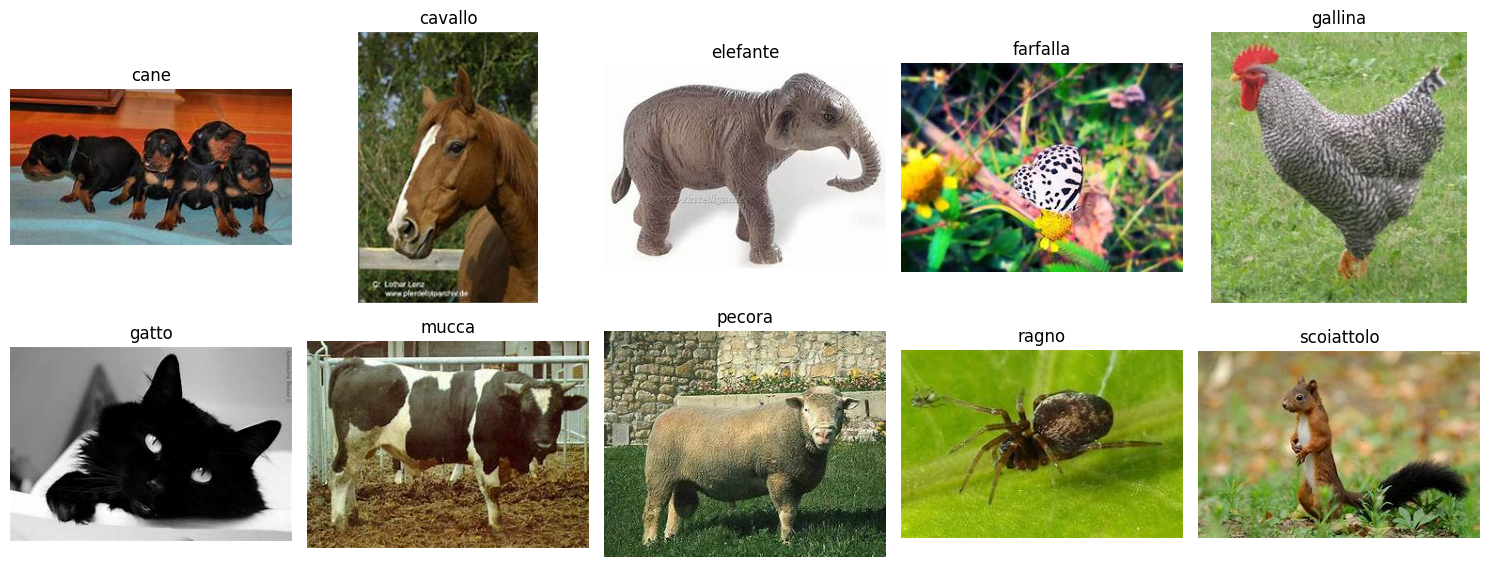

In [5]:
# Generate Visual
display_image_grid("/content/drive/MyDrive/Deep Learning Final Project/data/raw-img", 1)

Here there is blur in the squirrel picture, which could confuse the model. The horse picture also contains writings on the bottom.

There is also the presense of a human in the first picture of a sheep. The data preprocessing must take these things into account.

Now a distribution of the data will be visualized.

Category: cane, Number of Images: 4863
Category: cavallo, Number of Images: 2623
Category: elefante, Number of Images: 1438
Category: farfalla, Number of Images: 2072
Category: gallina, Number of Images: 3098
Category: gatto, Number of Images: 1677
Category: mucca, Number of Images: 1866
Category: pecora, Number of Images: 1820
Category: ragno, Number of Images: 4828
Category: scoiattolo, Number of Images: 1862


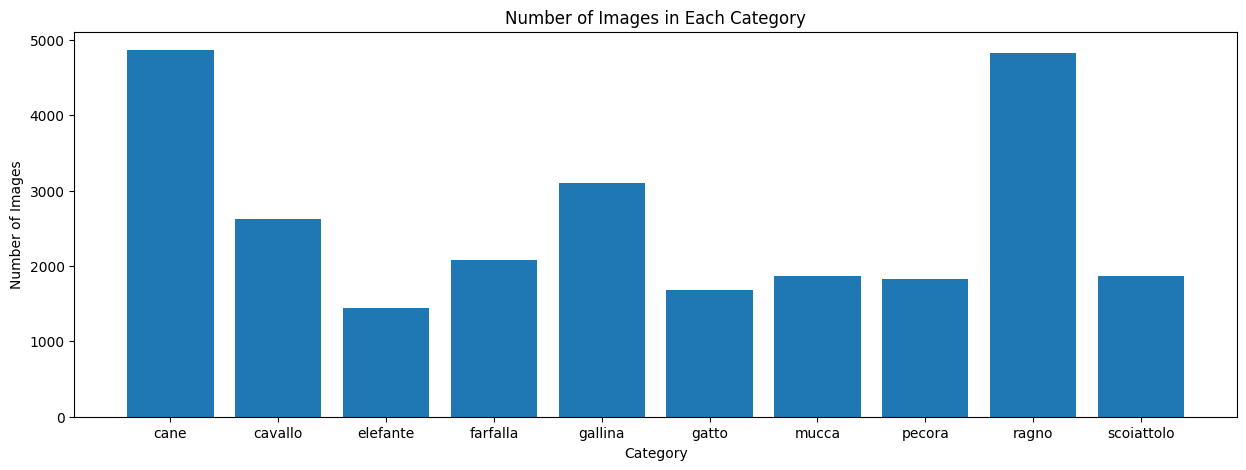

In [6]:
# count number of pictures in the raw_img folder per category and plot the results
import os
import matplotlib.pyplot as plt

def count_images_in_folders(folder_path):
    # get a list of folder names
    categories = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    categories.sort()

    # initialize a dictionary to store category counts
    category_counts = {}

    # iterate through each category folder
    for category in categories:
        category_path = os.path.join(folder_path, category)
        image_files = [f for f in os.listdir(category_path) if f.endswith(".jpeg") or f.endswith(".jpg")]
        num_images = len(image_files)
        category_counts[category] = num_images
        print(f"Category: {category}, Number of Images: {num_images}")

    # Plot the results
    plt.bar(category_counts.keys(), category_counts.values())
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.gcf().set_size_inches(15, 5)
    plt.show()

    return category_counts

# run the function
category_counts = count_images_in_folders("/content/drive/MyDrive/Deep Learning Final Project/data/raw-img")

The distribution of images is not equal among categories. Data processing must take this into account also.

Now a histogram view of the image distribution:

Text(0.5, 1.0, 'Histogram of Number of Images per Category')

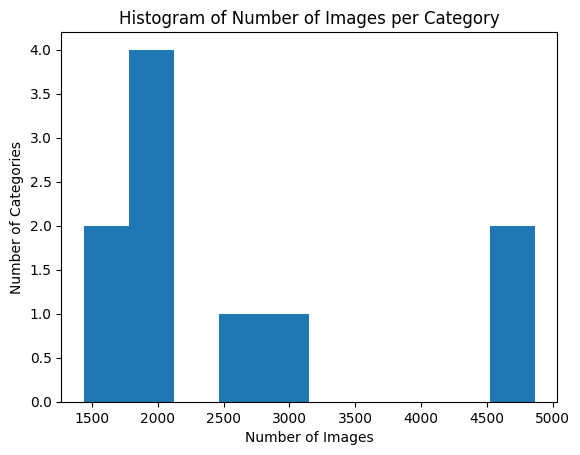

In [7]:
# histogram view of image distribution
plt.hist(category_counts.values(), bins=10, orientation='vertical')
plt.xlabel('Number of Images')
plt.ylabel('Number of Categories')
plt.title('Histogram of Number of Images per Category')

We can see from above that the majority of categories have 2000 or less pictures. Two categories have >4500 images.

### Summation of Observations

In summation of the observations, the following considerations must be addressed:

1. The model must be able to handle multiple image sizes
2. The model must locate an animal wherever it is in the picture
3. The model must be robust against random borders, watermarks, and image quality issues
4. The model must categorize if there are more than one animal present and must be able to decypher a human being present
5. The model must compensate for an unequal distribution of images among categories.

With these points in consideration, transformations can be applied to the dataset to increase robustness of the model.

#### Consideration #1
Before the image is processed by the model, the image size will need to be normalized.

#### Consideration #2
Random cropping of images is documented to help model performance in locating objects in various locations on an image.
Random rotation of images also helps.

#### Consideration #3
Gaussian blurring of images is documented to help model performance in dealing with different image quality.

#### Consideration #4
Random rotation may help with other animals or humans being in the image.

#### Consideration #5
Undersampling - to compensate for the unequal distribution, each category will be trained on 1438 images (lowest category).

Adding transformations is key to model training, so that the model learns the key features of a cat, for example, instead of being finely tuned to recognize an upright, undistorted picture of a cat.

Here are the transformations applied:

In [8]:
# define the transformation steps
import torchvision.transforms as transforms

# function to apply all transforms identified in EDA
def transformer():
    # define transformations (data augmentation and normalization)
    transform = transforms.Compose([
        # Consideration #4 - Random Rotation
        transforms.RandomRotation(degrees=90),
        # Consideration #2 - Random Cropping
        transforms.RandomCrop(32, padding=4),
        # Consideration #3 - Gaussian Blurring
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        # transform to tensor
        transforms.ToTensor(),
        # Consideration #1 - Normalize Images
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform

# Consideration #5
def undersample(path):
  # loop through each folder in path and create a copy with only 1500 files to undersampled-img
  import shutil
  import os
  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
      files = os.listdir(folder_path)[:1438]
      print(files)
      for i in range(len(files)):
        file = files[i]
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join("/content/drive/MyDrive/Deep Learning Final Project/data/undersampled-img", folder, file)
        shutil.copy(src_path, dst_path)

## Analysis and Approach

The GoogLeNet (2014) architecture proposes an interesting solution based on human biology called the "inception module [[1](https://arxiv.org/pdf/1409.4842)]." This proposal is based on the neuroscientific Hebbian Principle: "Neurons that fire together wire together."

This paper will incorporate an inception module similar to GoogLeNet's architecture here:

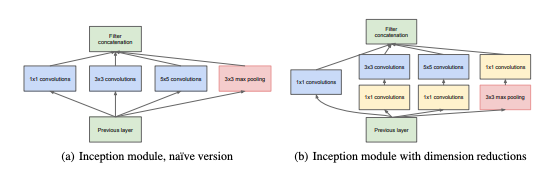

*Source* [[1](https://arxiv.org/pdf/1409.4842)]

### Proposed Architecture

Following the learnings from GoogLeNet, this paper will implement three convolutional layers, an inception module with 4 convolutional parts, a fully connected layer with four hidden layers, and one output layer.

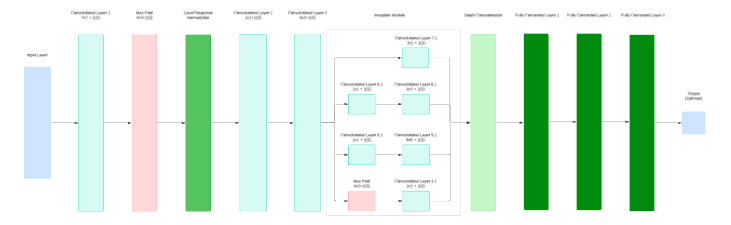

In [9]:
# !pip install torch torchvision
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# define CNN architecture
class CNN(nn.Module):
  def __init__(self, epochs, batch_size, learning_rate):
    super(CNN, self).__init__()
    #------------------ Architecture ------------------#
    # Convolutional Layer 1
    self.layer1 = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
      nn.ReLU(inplace=True),
      # Max Pooling
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      # Local Response Normalization
      nn.LocalResponseNorm(5)
    )

    # Convolutional Layer 2
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0),
        nn.ReLU(inplace=True)
    )

    # Convolutional Layer 3
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
    )

    # Inception Module
    self.inception1 = nn.Sequential(
        # Max Pooling
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        # Convolutional Layer 4.1
        nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=2),
        nn.ReLU(inplace=True)
    )

    self.inception2 = nn.Sequential(
        # Convolutional Layer 5.1
        nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
        nn.ReLU(inplace=True),
        # Convoliutional Layer 5.2
        nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True)
    )

    self.inception3 = nn.Sequential(
        # Convolutional Layer 6.1
        nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
        nn.ReLU(inplace=True),
        # Convolutional Layer 6.2
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
    )

    self.inception4 = nn.Sequential(
        # Convolutional Layer 7.1
        nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
        nn.ReLU(inplace=True)
    )

    # Fully Connected Layer 1
    self.fc1 = nn.Sequential(
        nn.LazyLinear(512),
        nn.ReLU(inplace=True)
    )

    # Fully Connected Layer 2
    self.fc2 = nn.Sequential(
        nn.LazyLinear(256),
        nn.ReLU(inplace=True)
    )

    # Fully Connected Layer 3
    self.fc3 = nn.Sequential(
        nn.LazyLinear(128),
        nn.ReLU(inplace=True)
    )

    # Output Softmax
    self.output = nn.Sequential(
        nn.LazyLinear(10),
        nn.Softmax(dim=1)
    )
    #------------------ Architecture ------------------#

    #------------------ Hyperparameters ------------------#
    # Loss and Optimizer
    self.loss = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    self.epochs = epochs
    self.batch_size = batch_size
    #------------------ Hyperparameters ------------------#

  # forward pass function
  def forward(self, x):
    # Initial Layers
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)

    # Inception Layer
    out1 = self.inception1(out)
    out2 = self.inception2(out)
    out3 = self.inception3(out)
    out4 = self.inception4(out)

    # Depth Concatenation
    out = torch.cat((out1, out2, out3, out4), 1)

    # flatten concatenation
    out = out.view(out.size(0), -1)

    # Fully Connected Layers
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    # Output
    out = self.output(out)

    return out

Now that the architecture is completed. The main funtion to train the CNN will be coded, beginning with the following hyperparameters:

* Epochs = 15
* Batch size = 24
* Learning rate = 0.001 (No scheduler)
* Adam Optimization
* Cross Entropy loss validation

In [11]:
import json

def calculate_accuracy(outputs, labels):
    # calculates the accuracy of predictions.
    prediction = torch.argmax(outputs, dim=1)
    num_correct = (prediction == labels).sum().item()
    num_total = labels.size(0)
    accuracy = num_correct / num_total
    return float(accuracy)

#------------------ Train Function ------------------#
def train(path, model):
  # initiate functions for dataset and loader
  dataset = torchvision.datasets.ImageFolder(root=path, transform=transformer())
  # split into train and validation
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
  # data loaders (pytorch)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=model.batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=model.batch_size, shuffle=True)

  # initiate criterion and optimizer
  criterion = model.loss
  optimizer = model.optimizer

  # initiate loss and accuracy history
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []

  # determine the device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # move the model to the device
  model.to(device)

  # train loop
  for epoch in range(model.epochs):
    # set model to train
    model.train()

    # set loss and accuracy meters
    losses = []
    accuracies = []

    # begin train on epoch
    for i, (inputs, labels) in enumerate(train_loader):
      # move inputs and labels to the device
      inputs, labels = inputs.to(device), labels.to(device)

      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # backward pass
      loss.backward()
      optimizer.step()

      # update statistics
      losses.append(loss.item())
      accuracies.append(calculate_accuracy(outputs.cpu(), labels.cpu()))

      # print every 100 batches
      if (i + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{model.epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # calculate and store the average loss for the epoch
    epoch_loss = float(sum(losses)) / float(len(losses))
    epoch_acc = sum(accuracies) / len(accuracies)

    # print training statistics
    print(
        f'Epoch: {epoch + 1} | Loss: {epoch_loss:.3f} | Accuracy: {epoch_acc:.3f}'
    )
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    # validation loss
    model.eval()
    with torch.no_grad():
      # set loss and accuracy meters
      losses = []
      accuracies = []
      for i, (inputs, labels) in enumerate(val_loader):
        # move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # run model
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # update statistics
        losses.append(loss.item())
        accuracies.append(calculate_accuracy(outputs.cpu(), labels.cpu()))

    # calculate validation loss
    val_epoch_loss = float(sum(losses)) / float(len(losses))
    val_epoch_acc = float(sum(accuracies)) / float(len(accuracies))

    # print validation statistics
    print(
        f'Epoch: {epoch + 1} | Validation Loss: {val_epoch_loss :.3f} | Validation Accuracy: {val_epoch_acc:.3f}'
    )
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

  return train_loss_history, val_loss_history, train_acc_history, val_acc_history
#------------------ Train Function ------------------#

# model name
model_name = 'Animal Classification-1'

# bring in the dataset
path = '/content/drive/MyDrive/Deep Learning Final Project/data/raw-img'

# initiate the model
model = CNN(epochs=25, batch_size=30, learning_rate=0.001)

# train the model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(path, model)

# save model
torch.save(model.state_dict(), f'/content/drive/MyDrive/Deep Learning Final Project/models/{model_name}.pth')

# save the results
with open(f'/content/drive/MyDrive/Deep Learning Final Project/results/{model_name}-results.json', 'w') as f:
  json.dump({
      'train_loss_history': train_loss_history,
      'val_loss_history': val_loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history
  }, f)

Epoch [1/25], Step [100/699], Loss: 2.2916
Epoch [1/25], Step [200/699], Loss: 2.2588
Epoch [1/25], Step [300/699], Loss: 2.3035
Epoch [1/25], Step [400/699], Loss: 2.1711
Epoch [1/25], Step [500/699], Loss: 2.2246
Epoch [1/25], Step [600/699], Loss: 2.3277
Epoch: 1 | Loss: 2.244 | Accuracy: 0.183
Epoch: 1 | Validation Loss: 2.243 | Validation Accuracy: 0.183
Epoch [2/25], Step [100/699], Loss: 2.1635
Epoch [2/25], Step [200/699], Loss: 2.2618
Epoch [2/25], Step [300/699], Loss: 2.1976
Epoch [2/25], Step [400/699], Loss: 2.2185
Epoch [2/25], Step [500/699], Loss: 2.2237
Epoch [2/25], Step [600/699], Loss: 2.2693
Epoch: 2 | Loss: 2.241 | Accuracy: 0.186
Epoch: 2 | Validation Loss: 2.238 | Validation Accuracy: 0.188
Epoch [3/25], Step [100/699], Loss: 2.2026
Epoch [3/25], Step [200/699], Loss: 2.2386
Epoch [3/25], Step [300/699], Loss: 2.2133
Epoch [3/25], Step [400/699], Loss: 2.2566
Epoch [3/25], Step [500/699], Loss: 2.2149
Epoch [3/25], Step [600/699], Loss: 2.2180
Epoch: 3 | Loss: 2

## Results and Analysis

As seen from the code and output below, the inception model showed great promise, but it was incredibly slow to train. The training was expensive both resource wise (using 132 google compute units (~$25)) and took 8 hours to train on 25 epochs. The model did successfully gain accuracy and decrease cross entropy loss as it iterated through the epochs.

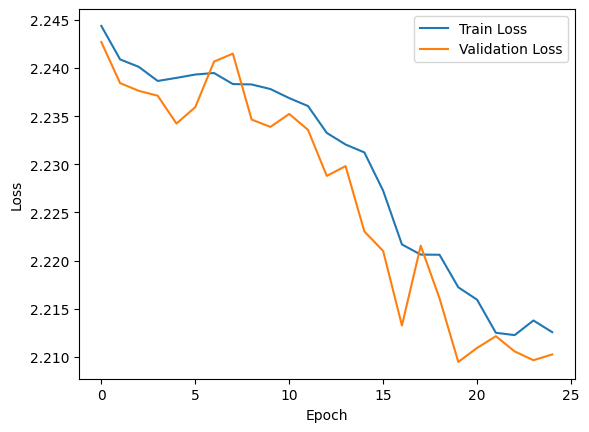

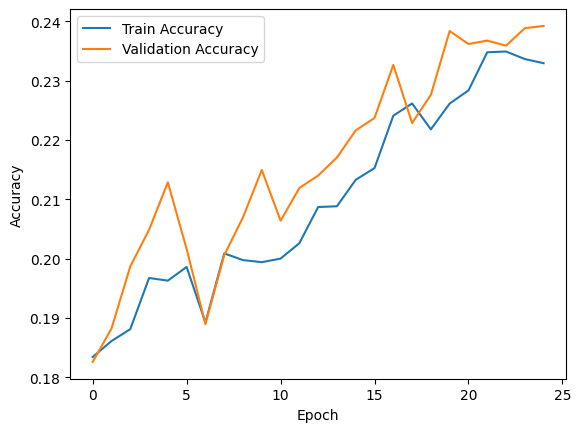

In [4]:
# plot loss histories and accuracy plots
import matplotlib.pyplot as plt
import json

# model name
model_name = 'Animal Classification-1'

# load json
with open(f'/content/drive/MyDrive/Deep Learning Final Project/results/{model_name}-results.json', 'r') as f:
  results = json.load(f)

# plot loss histories
plt.plot(results['train_loss_history'], label='Train Loss')
plt.plot(results['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy histories
plt.plot(results['train_acc_history'], label='Train Accuracy')
plt.plot(results['val_acc_history'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Hyperparameter Tuning

The above computations cost about $25 on Google Colab A100 GPU compute credits. It took approximately 8 hours to train on 25 epohcs.

Given more time and money, the following hyperparameters could be tuned:

* Greatly increase the number of epochs - the model above did not have enough epochs to converge, but showed promise in continually increasing accuracy and decreasing loss it iterated through the epochs. GoogLeNet was trained on approximately 500 epochs.
* Start with a higher learning rate and add a learning rate scheduled reduction to increase convergence speed.

Below is sample code implementing this change (will not be run for time and resource constraints):

In [ ]:
import json
from torch.optim.lr_scheduler import StepLR

def calculate_accuracy(outputs, labels):
    # calculates the accuracy of predictions.
    prediction = torch.argmax(outputs, dim=1)
    num_correct = (prediction == labels).sum().item()
    num_total = labels.size(0)
    accuracy = num_correct / num_total
    return float(accuracy)

#------------------ Train Function ------------------#
def train(path, model):
  # initiate functions for dataset and loader
  dataset = torchvision.datasets.ImageFolder(root=path, transform=transformer())
  # split into train and validation
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
  # data loaders (pytorch)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=model.batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=model.batch_size, shuffle=True)

  # initiate criterion and optimizer
  criterion = model.loss
  optimizer = model.optimizer

  # initiate learning rate scheduler
  learning_scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

  # initiate loss and accuracy history
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []

  # determine the device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # move the model to the device
  model.to(device)

  # train loop
  for epoch in range(model.epochs):
    # set model to train
    model.train()

    # set loss and accuracy meters
    losses = []
    accuracies = []

    # begin train on epoch
    for i, (inputs, labels) in enumerate(train_loader):
      # move inputs and labels to the device
      inputs, labels = inputs.to(device), labels.to(device)

      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # backward pass
      loss.backward()
      optimizer.step()

      # update statistics
      losses.append(loss.item())
      accuracies.append(calculate_accuracy(outputs.cpu(), labels.cpu()))

      # print every 100 batches
      if (i + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{model.epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # calculate and store the average loss for the epoch
    epoch_loss = float(sum(losses)) / float(len(losses))
    epoch_acc = sum(accuracies) / len(accuracies)

    # print training statistics
    print(
        f'Epoch: {epoch + 1} | Loss: {epoch_loss:.3f} | Accuracy: {epoch_acc:.3f}'
    )
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    # validation loss
    model.eval()
    with torch.no_grad():
      # set loss and accuracy meters
      losses = []
      accuracies = []
      for i, (inputs, labels) in enumerate(val_loader):
        # move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # run model
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # update statistics
        losses.append(loss.item())
        accuracies.append(calculate_accuracy(outputs.cpu(), labels.cpu()))

    # calculate validation loss
    val_epoch_loss = float(sum(losses)) / float(len(losses))
    val_epoch_acc = float(sum(accuracies)) / float(len(accuracies))

    # print validation statistics
    print(
        f'Epoch: {epoch + 1} | Validation Loss: {val_epoch_loss :.3f} | Validation Accuracy: {val_epoch_acc:.3f}'
    )
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

  return train_loss_history, val_loss_history, train_acc_history, val_acc_history
#------------------ Train Function ------------------#

# model name
model_name = 'Animal Classification-1'

# bring in the dataset
path = '/content/drive/MyDrive/Deep Learning Final Project/data/raw-img'

# initiate the model
model = CNN(epochs=100, batch_size=30, learning_rate=0.0015)

# train the model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(path, model)

# save model
torch.save(model.state_dict(), f'/content/drive/MyDrive/Deep Learning Final Project/models/{model_name}.pth')

# save the results
with open(f'/content/drive/MyDrive/Deep Learning Final Project/results/{model_name}-results.json', 'w') as f:
  json.dump({
      'train_loss_history': train_loss_history,
      'val_loss_history': val_loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history
  }, f)

## Conclusion

The inception module performs well, but is computationally very expensive. Running 25 epochs on Google's A100 GPU compute server (highest available for Google Colab Pro subscribers) takes approximately 132 compute units and 8 hours of runtime.

To improve convergence speed, a learning rate scheduler with a higher beginning learning rate on the Adam optmizer can be applied.

Possible future work:

* Instead of 4 inception layers, try 2 and compare the first 10 epochs for performance. If lowering the architecture complexity acheives the same results, computation time could be improved.
* Use more powerful GPU. AWS has many GPU compute options on EC2 that are quite affordable for one-time computational tasks. Trying a more powerful GPU on AWS may increase speed to convergence.